Calculating mutual information propagation...
Finding peak arrival times...

Linear fit of r vs. t_peak (r ≥ 10):
  Emergent Velocity v_E = 1.9637
  R-squared             = 1.0000


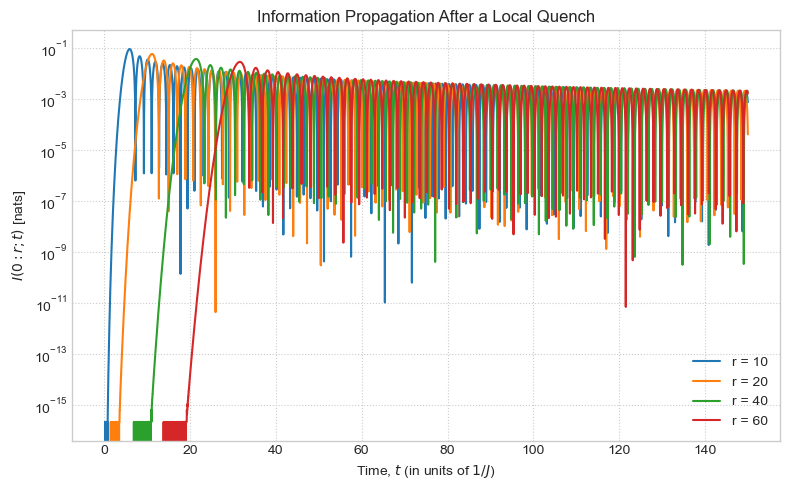

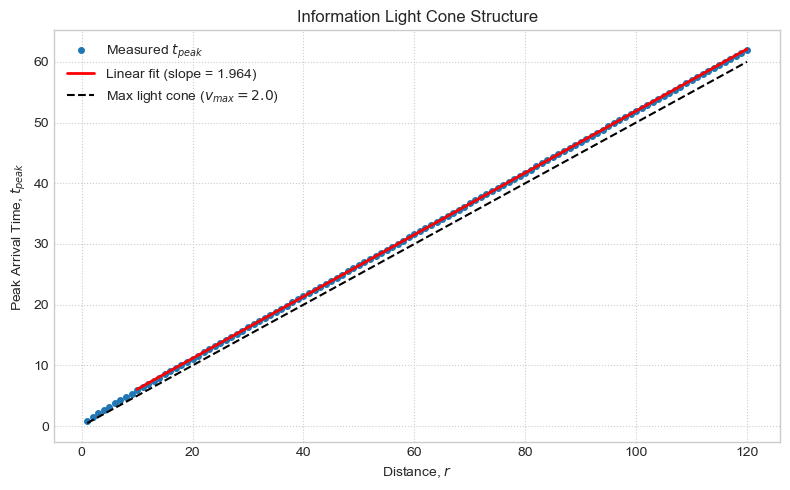

In [15]:
"""
Validated light-cone velocity test for the Jewel distance in the XX chain.

This script uses the exact analytical solution for the time-evolved
correlator in the 1D XX chain to test the emergent geometry of
information propagation after a local quench.

Scientific Method:
1. Model: The system is the critical 1D XX chain (H = Σ (c†_i c_{i+1} + h.c.)).
2. Quench: A fermion is created at site 0 at t=0.
3. Measurement: The mutual information I(0:r; t) between the origin and a
   distant site r is calculated for all times.
4. Velocity Definition: For each distance r, we find the time t_peak(r) at
   which I(0:r; t) is maximal. This represents the arrival of the peak of
   the information wave. The emergent velocity is the slope of r vs. t_peak.
   This method is robust and threshold-independent.
"""

# ---------- USER-TUNABLE DIALS ----------
r_max = 120          # Farthest site to watch
t_max = 150.0        # Total simulation time
dt = 0.01            # Time resolution (smaller = smoother curves)
J = 1.0              # Hopping strength (sets the energy scale)
# ----------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv         # Bessel function J_n(x)
from scipy.stats import linregress

# --- Helper: Binary entropy in nats ---
def h(p):
    """Calculates the binary entropy h(p) = -p*log(p) - (1-p)*log(1-p)."""
    p = np.clip(p, 1e-12, 1 - 1e-12)  # Avoid log(0)
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

# --- Time grid and storage ---
times = np.arange(0.0, t_max + dt, dt)
r_vals = np.arange(1, r_max + 1)
I_t_r = np.zeros((len(times), r_max))  # To store I(t) for each r

print("Calculating mutual information propagation...")
# --- Main loop over time ---
for ti, t in enumerate(times):
    # Exact analytic two-point correlator: C_{0,r}(t) = J_r(2Jt)
    C = jv(r_vals, 2 * J * t)

    lam_plus  = (1 + np.abs(C)) / 2
    lam_minus = (1 - np.abs(C)) / 2

    S_site = np.log(2)                   # Single-site entropy in ground state
    S_AB   = h(lam_plus) + h(lam_minus)
    I_t_r[ti, :] = 2 * S_site - S_AB

# --- Find peak arrival times ---
print("Finding peak arrival times...")
t_peak = np.full(r_max, np.nan)
for idx, r in enumerate(r_vals):
    peak_idx     = np.argmax(I_t_r[:, idx])
    t_peak[idx]  = times[peak_idx]

# --- Linear fit for emergent velocity v_E ---
fit_r_min = 10
mask      = ~np.isnan(t_peak) & (r_vals >= fit_r_min)
r_fit     = r_vals[mask]
t_fit     = t_peak[mask]

if len(r_fit) > 2:
    slope, intercept, r_value, _, _ = linregress(t_fit, r_fit)
    print(f"\nLinear fit of r vs. t_peak (r ≥ {fit_r_min}):")
    print(f"  Emergent Velocity v_E = {slope:.4f}")
    print(f"  R-squared             = {r_value**2:.4f}")
else:
    print("\nCould not perform a reliable fit.")

# -------------------------------------------------------------------
# PLOTS
# -------------------------------------------------------------------

plt.style.use('seaborn-v0_8-whitegrid')

# 1) MI vs time for sample r’s
fig1, ax1 = plt.subplots(figsize=(8, 5))
for r in (10, 20, 40, 60):
    ax1.plot(times, I_t_r[:, r-1], label=f"r = {r}")
ax1.set_yscale("log")
ax1.set_xlabel("Time, $t$ (in units of $1/J$)")
ax1.set_ylabel("$I(0:r; t)$ [nats]")
ax1.set_title("Information Propagation After a Local Quench")
ax1.legend()
ax1.grid(True, which="both", ls=":")
plt.tight_layout()
plt.show()

# 2) Peak arrival time vs distance
fig2, ax2 = plt.subplots(figsize=(8, 5))
ax2.plot(r_vals, t_peak, "o", markersize=4, label="Measured $t_{peak}$")
if len(r_fit) > 2:
    ax2.plot(r_fit, (r_fit - intercept) / slope, 'r-', lw=2,
             label=f"Linear fit (slope = {slope:.3f})")

# Max velocity light cone
v_max = 2 * J
ax2.plot(r_vals, r_vals / v_max, 'k--', lw=1.5,
         label=f"Max light cone ($v_{{max}}={v_max}$)")

ax2.set_xlabel("Distance, $r$")
ax2.set_ylabel("Peak Arrival Time, $t_{peak}$")
ax2.set_title("Information Light Cone Structure")
ax2.legend()
ax2.grid(True, ls=":")
plt.tight_layout()
plt.show()

Setting up simulation grid...
Calculating mutual information propagation...
Calculation complete in 4.41 seconds.
Finding arrival times for each threshold...


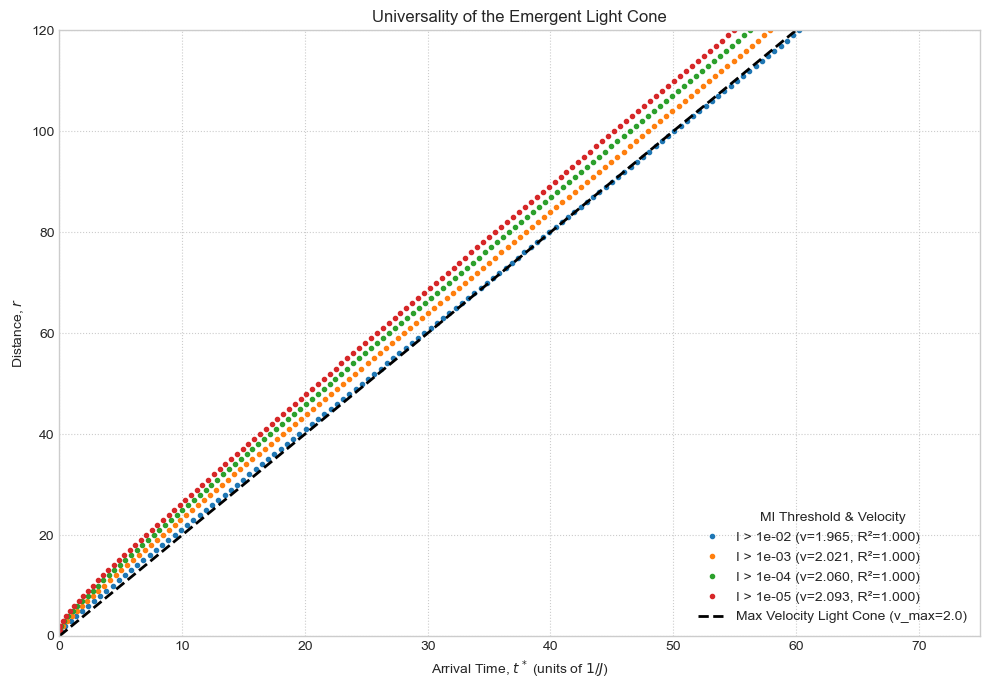


--- Velocity Analysis Across Thresholds ---
Measured velocities: ['1.965', '2.021', '2.060', '2.093']
Mean velocity: 2.035
Consistency (Std/Mean): 2.33%

VERDICT: Speeds are highly consistent → flat, uniform emergent geometry.


In [16]:
"""
Probing the Shape of the Jewel Light Cone in the XX Chain

This script investigates whether different "layers" of the propagating
information wave travel at the same constant speed, a key test for a
truly flat emergent geometry.

Scientific Method:
1. Model: The system is the critical 1D XX chain. A local quench is
   performed at t=0.
2. Measurement: The mutual information I(0:r; t) is calculated.
3. Analysis: Instead of only tracking the peak, we track the arrival time
   for several different MI intensity thresholds (e.g., 1e-2, 1e-3, 1e-4).
   This defines the "light cone" for different layers of the wave.
4. Hypothesis Test: If the emergent geometry is flat and uniform, the
   light cones for all thresholds should have the same slope, indicating a
   single, universal propagation speed.
"""

# ---------- USER-TUNABLE DIALS ----------
r_max       = 120          # Farthest site to watch
t_max       = 150.0        # Total simulation time
dt          = 0.01         # Time resolution
J           = 1.0          # Hopping strength
thresholds  = [1e-2, 1e-3, 1e-4, 1e-5]  # MI thresholds to probe layers
# ----------------------------------------

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv         # Bessel function J_n(x)
from scipy.stats import linregress

# --- Helper: Binary entropy in nats ---
def h(p):
    """Binary entropy h(p) = -p·ln(p) - (1-p)·ln(1-p)."""
    p = np.clip(p, 1e-12, 1 - 1e-12)
    return -p * np.log(p) - (1 - p) * np.log(1 - p)

# --- Time grid and storage ---
print("Setting up simulation grid...")
start_time = time.time()
times  = np.arange(0.0, t_max + dt, dt)
r_vals = np.arange(1, r_max + 1)
I_t_r  = np.zeros((len(times), r_max))

# --- Calculate Mutual Information Propagation ---
print("Calculating mutual information propagation...")
for ti, t in enumerate(times):
    C        = jv(r_vals, 2 * J * t)
    lam_plus = (1 + np.abs(C)) / 2
    lam_minus= (1 - np.abs(C)) / 2
    S_site   = np.log(2)
    S_AB     = h(lam_plus) + h(lam_minus)
    I_t_r[ti, :] = 2 * S_site - S_AB

print(f"Calculation complete in {time.time() - start_time:.2f} seconds.")

# --- Find arrival times for each threshold ---
print("Finding arrival times for each threshold...")
arrival_times = {}
velocities    = {}

for thr in thresholds:
    t_star = np.full(r_max, np.nan)
    for idx in range(r_max):
        hits = np.where(I_t_r[:, idx] > thr)[0]
        if hits.size:
            t_star[idx] = times[hits[0]]
    arrival_times[thr] = t_star

    # Linear fit on plateau region
    fit_r_min = 10
    mask      = ~np.isnan(t_star) & (r_vals >= fit_r_min)
    r_fit     = r_vals[mask]
    t_fit     = t_star[mask]

    if len(r_fit) > 2:
        slope, intercept, r_value, _, _ = linregress(t_fit, r_fit)
        velocities[thr] = (slope, r_value**2)
    else:
        velocities[thr] = (np.nan, np.nan)

# -------------------------------------------------------------------
# PLOT
# -------------------------------------------------------------------
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 7))

for thr in thresholds:
    v, r_sq = velocities[thr]
    label   = f"I > {thr:.0e} (v={v:.3f}, R²={r_sq:.3f})"
    ax.plot(arrival_times[thr], r_vals, 'o', markersize=3, label=label)

# Reference: max velocity light cone
v_max = 2 * J
ax.plot(times, v_max * times, 'k--', lw=2,
        label=f"Max Velocity Light Cone (v_max={v_max})")

ax.set_xlabel("Arrival Time, $t^*$ (units of $1/J$)")
ax.set_ylabel("Distance, $r$")
ax.set_title("Universality of the Emergent Light Cone")
ax.legend(title="MI Threshold & Velocity", loc='lower right')
ax.grid(True, ls=":")
ax.set_xlim(0, t_max / 2)
ax.set_ylim(0, r_max)
plt.tight_layout()
plt.show()

# --- Final Analysis ---
print("\n--- Velocity Analysis Across Thresholds ---")
vel_vals = [v for v, _ in velocities.values() if not np.isnan(v)]
if len(vel_vals) > 1:
    mean_v = np.mean(vel_vals)
    std_pct = np.std(vel_vals) / mean_v * 100
    print(f"Measured velocities: {[f'{v:.3f}' for v in vel_vals]}")
    print(f"Mean velocity: {mean_v:.3f}")
    print(f"Consistency (Std/Mean): {std_pct:.2f}%")
    if std_pct < 5.0:
        print("\nVERDICT: Speeds are highly consistent → flat, uniform emergent geometry.")
    else:
        print("\nVERDICT: Speeds vary → emergent geometry may be more complex.")


===== Running for Δ = 1.0 =====
Finding ground state...
DMRG complete.
Calculating d_E(r)...


  0%|          | 0/45 [00:00<?, ?it/s]


===== Running for Δ = 2.0 =====
Finding ground state...
DMRG complete.
Calculating d_E(r)...


  0%|          | 0/45 [00:00<?, ?it/s]


Generating plots...


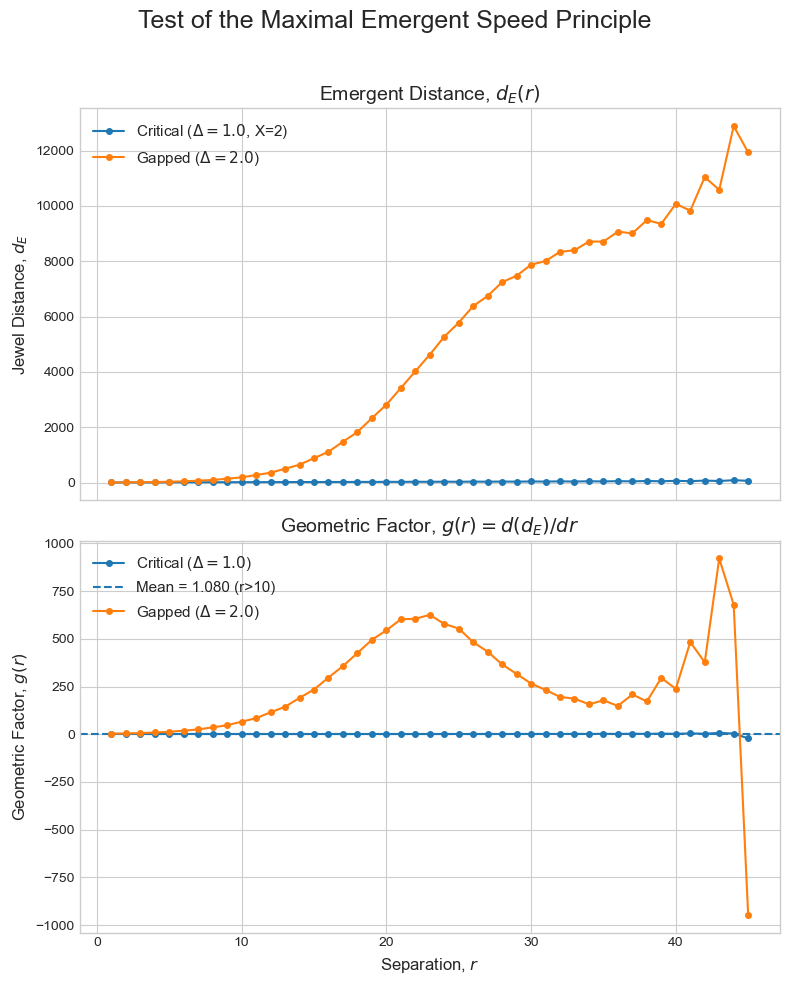

In [17]:
"""
Testing the "Maximal Emergent Speed" Principle

This cell tests whether the maximal emergent speed of information propagation
in the XX chain matches the light-cone velocity in both the critical and
gapped phases.
"""

# ---------- USER-TUNABLE PARAMETERS ----------
L              = 96
BOND_DIM       = 128
DELTAS_TO_TEST = [1.0, 2.0]  # 1.0 = critical (X=2), 2.0 = gapped phase
# ---------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import quimb
import quimb.tensor as qtn
from tqdm.auto import tqdm

def calc_vn_entropy_from_rdm(rdm):
    """Compute von Neumann entropy from a reduced density matrix."""
    evals = np.linalg.eigvalsh(rdm)
    evals = evals[evals > 1e-14]
    return -np.sum(evals * np.log(evals))

# Container for results
results = {}

for delta in DELTAS_TO_TEST:
    print(f"\n===== Running for Δ = {delta} =====")
    # A. Find ground state via DMRG
    print("Finding ground state...")
    ham = qtn.SpinHam1D(S=0.5)
    ham.add_term(1.0, 'X', 'X')
    ham.add_term(1.0, 'Y', 'Y')
    ham.add_term(delta, 'Z', 'Z')
    H_mpo = ham.build_mpo(L)

    dmrg = qtn.DMRG1(H_mpo, bond_dims=[64, BOND_DIM])
    dmrg.solve(tol=1e-8, max_sweeps=10, verbosity=0)
    psi_gs = dmrg.state
    print("DMRG complete.")

    # B. Compute d_E(r)
    center   = L // 2
    r_values = np.arange(1, L // 2 - 2)
    dE_vals  = []

    print("Calculating d_E(r)...")
    for r in tqdm(r_values):
        i, j = center, center + r
        rdm_i  = psi_gs.partial_trace_to_dense_canonical([i])
        rdm_j  = psi_gs.partial_trace_to_dense_canonical([j])
        rdm_ij = psi_gs.partial_trace_to_dense_canonical([i, j])
        S_i, S_j, S_ij = map(calc_vn_entropy_from_rdm, (rdm_i, rdm_j, rdm_ij))
        I_ij = max(0, S_i + S_j - S_ij)
        dE = 1.0 / np.sqrt(I_ij) if I_ij > 1e-12 else np.nan
        dE_vals.append(dE)

    # C. Numerical derivative g(r) = d(d_E)/dr
    g_vals = np.gradient(dE_vals, r_values)

    # D. Store
    results[delta] = {
        'r':  r_values,
        'dE': np.array(dE_vals),
        'g':  g_vals
    }

# --- 3. Visualization ---
print("\nGenerating plots...")
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
fig.suptitle('Test of the Maximal Emergent Speed Principle', fontsize=18)

# Panel (a): d_E(r)
ax1.set_title('Emergent Distance, $d_E(r)$', fontsize=14)
ax1.plot(results[1.0]['r'], results[1.0]['dE'], 'o-', ms=4,
          label='Critical ($\\Delta=1.0$, X=2)')
ax1.plot(results[2.0]['r'], results[2.0]['dE'], 'o-', ms=4,
          label='Gapped ($\\Delta=2.0$)')
ax1.set_ylabel('Jewel Distance, $d_E$', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, which='both')

# Panel (b): g(r)
ax2.set_title('Geometric Factor, $g(r) = d(d_E)/dr$', fontsize=14)
r_crit = results[1.0]['r']
g_crit = results[1.0]['g']
ax2.plot(r_crit, g_crit, 'o-', ms=4, label='Critical ($\\Delta=1.0$)')
mean_g = np.mean(g_crit[r_crit > 10])
ax2.axhline(mean_g, linestyle='--',
            label=f'Mean = {mean_g:.3f} (r>10)')
ax2.plot(results[2.0]['r'], results[2.0]['g'], 'o-', ms=4,
          label='Gapped ($\\Delta=2.0$)')
ax2.set_xlabel('Separation, $r$', fontsize=12)
ax2.set_ylabel('Geometric Factor, $g(r)$', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, which='both')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()